In [7]:
YOUR_API_KEY = 'W1KNO2X49YLY9LTB'

practice from https://github.com/RomelTorres/alpha_vantage

In [8]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
ts = TimeSeries(key=YOUR_API_KEY, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2020-11-17 20:00:00   214.20   214.20  214.20    214.20      347.0
2020-11-17 19:59:00   214.21   214.21  214.21    214.21      426.0


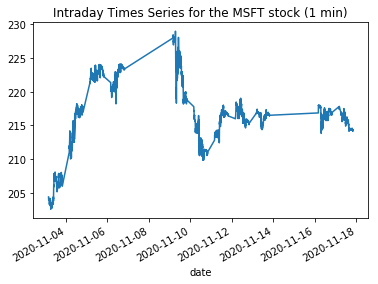

In [9]:
# from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
%matplotlib inline
# ts = TimeSeries(key='YOUR_API_KEY', output_format='pandas')
# data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
data['4. close'].plot()
plt.title('Intraday Times Series for the MSFT stock (1 min)')
plt.show()

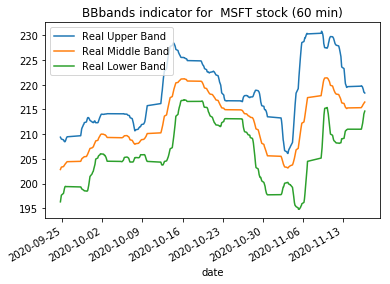

In [5]:
from alpha_vantage.techindicators import TechIndicators
# import matplotlib.pyplot as plt

ti = TechIndicators(key='YOUR_API_KEY', output_format='pandas')
data, meta_data = ti.get_bbands(symbol='MSFT', interval='60min', time_period=60)
data.plot()
plt.title('BBbands indicator for  MSFT stock (60 min)')
plt.show()

Turorial from https://www.datacamp.com/community/tutorials/lstm-python-stock-market

In [20]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [21]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'W1KNO2X49YLY9LTB'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Data saved to : stock_market_data-AAL.csv


In [22]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


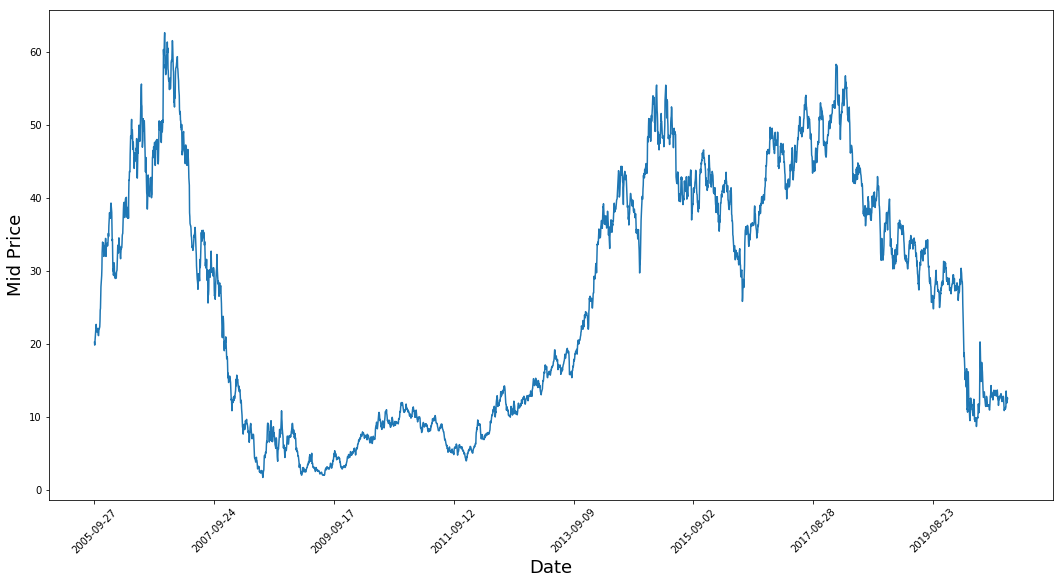

In [23]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [25]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0

In [27]:
len(high_prices)

3813

In [28]:
train_data = mid_prices[:3000]
test_data = mid_prices[3000:] #decreased from 11000, my data goes back to 2005, tutorial data goes back to 1970

In [30]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.values.reshape(-1,1)
test_data = test_data.values.reshape(-1,1)

# error AttributeError: 'Series' object has no attribute 'reshape' 
#solved Y.values.reshape

In [36]:
# # Train the Scaler with training data and smooth data
smoothing_window_size = 200
for di in range(0,2400,smoothing_window_size): #
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

#ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
# lowered the window size and range

In [37]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [38]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(3000): #11000 --> 3000
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [39]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00071


MSE error for standard averaging: 0.00418 from tutorial 

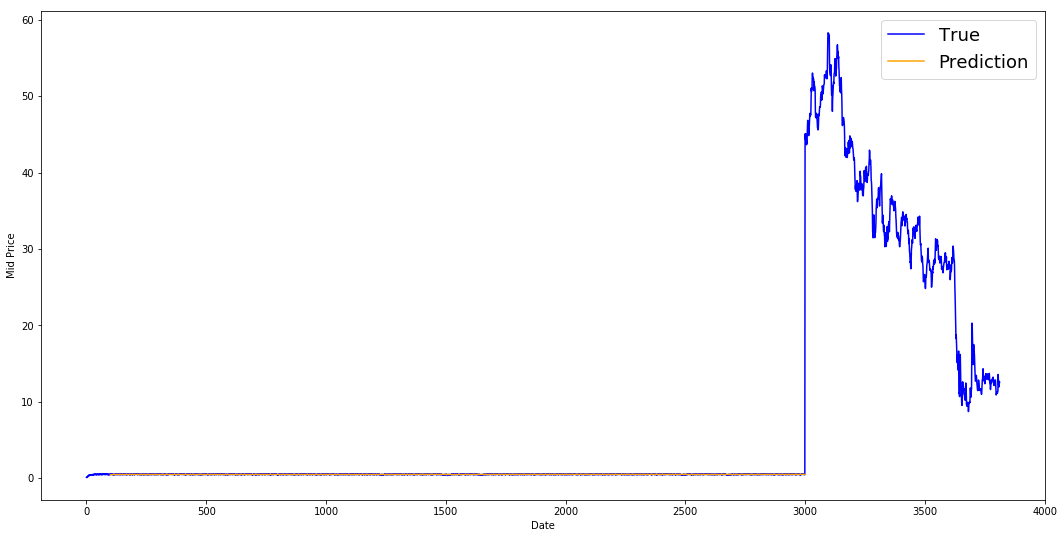

In [40]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [43]:
import requests

base_url = 'https://www.alphavantage.co/query?'
params = {'function': 'OVERVIEW',
         'symbol': 'IBM',
         'apikey': YOUR_API_KEY}

response = requests.get(base_url, params=params)

print(response.json())
test = response.json()['Name']
print(test)

{'Symbol': 'IBM', 'AssetType': 'Common Stock', 'Name': 'International Business Machines Corporation', 'Description': "International Business Machines Corporation operates as an integrated solutions and services company worldwide. Its Cloud & Cognitive Software segment offers software for vertical and domain-specific solutions in health, financial services, and Internet of Things (IoT), weather, and security software and services application areas; and customer information control system and storage, and analytics and integration software solutions to support client mission critical on-premise workloads in banking, airline, and retail industries. It also offers middleware and data platform software, including Red Hat, which enables the operation of clients' hybrid multi-cloud environments; and Cloud Paks, WebSphere distributed, and analytics platform software, such as DB2 distributed, information integration, and enterprise content management, as well as IoT, Blockchain and AI/Watson pl

In [49]:
from tqdm import tqdm

def request_stock_price_hist(symbol, token, sample = False):
    if sample == False:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize=full&apikey={}'
    else:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 7))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount", "split cf"]
    df['date'] = date
    return df

In [50]:
df = request_stock_price_hist('IBM', 'REPLACE_YOUR_TOKEN')
# df.to_csv('output.csv')

Retrieving stock price data from Alpha Vantage (This may take a while)...


  0%|          | 4/5297 [00:00<02:35, 34.14it/s]

Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 5297/5297 [01:45<00:00, 50.21it/s]


In [51]:
df.head()

,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,117.6,118.54,117.07,117.7,117.7,4134455,0.0000,1.0,2020-11-17
1,118.3,118.55,117.12,118.36,118.36,5293385,0.0000,1.0,2020-11-16
2,115.19,117.37,115.01,116.85,116.85,4683512,0.0000,1.0,2020-11-13
3,115.63,116.37,113.48,114.5,114.5,6500799,0.0000,1.0,2020-11-12
4,118.12,118.35,116.22,117.2,117.2,4289601,0.0000,1.0,2020-11-11


In [58]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [60]:
df['high'] = df['high'].astype(float)

In [61]:
df['low'] = df['low'].astype(float)

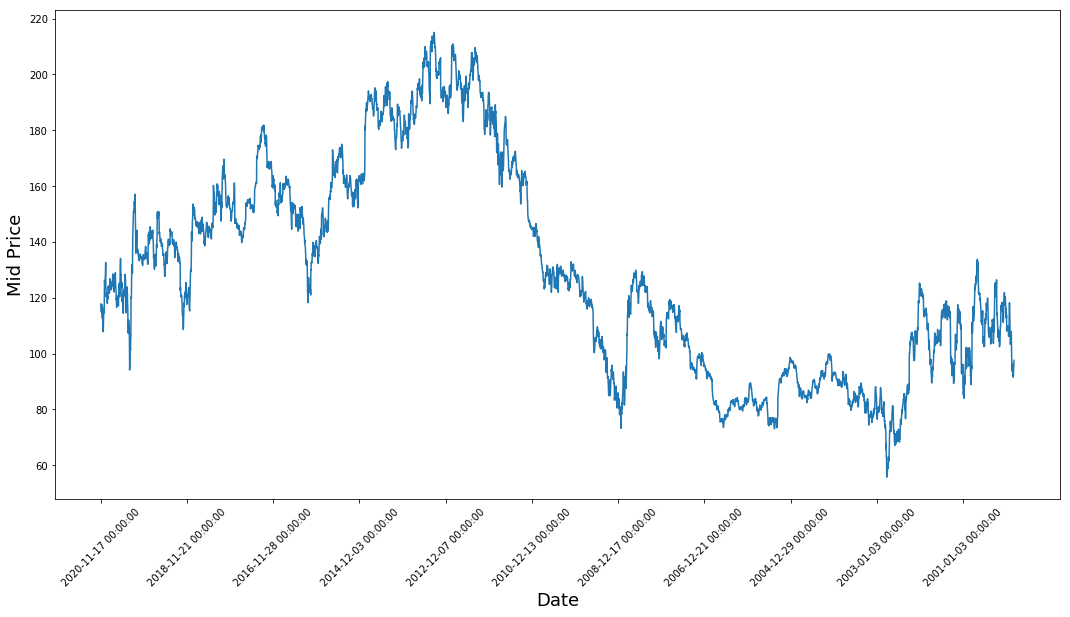

In [63]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [64]:
!pip install html-table-parser-python3

# Publicly Traded Companies

data table acquired from Fintel.io for Publicly Traded Drugs Companies - SIC Code 283

In [68]:
sic_283 = pd.read_csv("SIC_Code_283.csv")

In [70]:
sic_283.head()

,Exchange,Ticker,Country,Name,Market Cap ($M)
0,NASDAQ,ATNF,US,180 Life Sciences Corp.,12
1,OTC,FFNTF,US,4Front Ventures Corp,89
2,NASDAQ,ETNB,US,"89bio, Inc.",520
3,NASDAQ,NMTR,US,"9 Meters Biopharma, Inc.",145
4,NASDAQ,ACIU,US,AC Immune SA,370


In [71]:
sic_283.shape

(1161, 5)

In [72]:
CT_company_name = pd.read_csv("CT_company_name.csv")

In [74]:
CT_company_name.head()


,Unnamed: 0,company_name,count
0,0,GlaxoSmithKline,2667
1,1,Pfizer,2171
2,2,AstraZeneca,1771
3,3,Merck Sharp & Dohme Corp.,1740
4,4,Novartis Pharmaceuticals,1630


In [75]:
print(CT_company_name.shape)

(8488, 3)


In [76]:
del CT_company_name['Unnamed: 0']

In [84]:
 CT_company_name = CT_company_name.rename(columns={'company_name':'Name', 'count':'Trial_count'})

In [85]:
CT_company_name.head()

,Name,Trial_count
0,GlaxoSmithKline,2667
1,Pfizer,2171
2,AstraZeneca,1771
3,Merck Sharp & Dohme Corp.,1740
4,Novartis Pharmaceuticals,1630


In [86]:
 df_new = pd.merge(left=sic_283, right=CT_company_name, left_on='Name', right_on='Name')

In [87]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 219
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Exchange         218 non-null    object
 1   Ticker           220 non-null    object
 2   Country          220 non-null    object
 3   Name             220 non-null    object
 4   Market Cap ($M)  188 non-null    object
 5   Trial_count      220 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 12.0+ KB


In [92]:
pd.set_option('display.max_rows', 500)

In [93]:
df_new.sort_values(by="Trial_count", ascending=False)

,Exchange,Ticker,Country,Name,Market Cap ($M),Trial_count
182,OTC,SNYNF,US,Sanofi,"126,592",1086
183,NASDAQ,SNY,US,Sanofi,"126,893",1086
181,NaN,SANFP,FR,Sanofi,NaN,1086
179,EPA,SANNV,FR,Sanofi,NaN,1086
180,EPA,SAN,FR,Sanofi,NaN,1086
184,NASDAQ,GCVRZ,US,Sanofi,652,1086
139,XCSE,NOVOB,DK,Novo Nordisk A/S,NaN,735
80,EBR,GLPG,BE,Galapagos NV,NaN,85
98,NASDAQ,IONS,US,"Ionis Pharmaceuticals, Inc.","7,086",71
201,NASDAQ,VVUS,US,"VIVUS, Inc.",8,38


In [97]:
for ticker in df_new['Ticker'][:5]: # write a function  that takes ticker name from list and calls stock prices and converts daata and returns graph
    print(ticker)
    

ETNB
NMTR
ACIU
AIM
AMAG


In [98]:
ETNB = request_stock_price_hist('ETNB', 'REPLACE_YOUR_TOKEN')

Retrieving stock price data from Alpha Vantage (This may take a while)...


  6%|▌         | 15/259 [00:00<00:01, 147.77it/s]

Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 259/259 [00:00<00:00, 349.26it/s]


In [99]:
ETNB

,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,26.99,27.295,25.595,26.15,26.15,217864,0.0000,1.0,2020-11-18
1,27.88,28.24,26.4,26.67,26.67,106272,0.0000,1.0,2020-11-17
2,26.92,28.25,26.66,28.08,28.08,257809,0.0000,1.0,2020-11-16
3,25.24,27.23,25.02,26.88,26.88,226335,0.0000,1.0,2020-11-13
4,24.94,25.39,24.22,25.08,25.08,351978,0.0000,1.0,2020-11-12
5,25.72,25.72,24.09,24.79,24.79,282626,0.0000,1.0,2020-11-11
6,25.12,25.23,24.3,24.3,24.3,156823,0.0000,1.0,2020-11-10
7,25.13,25.37,24.66,24.99,24.99,123242,0.0000,1.0,2020-11-09
8,24.75,24.99,24.4201,24.68,24.68,65308,0.0000,1.0,2020-11-06
9,24.99,25.45,24.32,24.72,24.72,78382,0.0000,1.0,2020-11-05


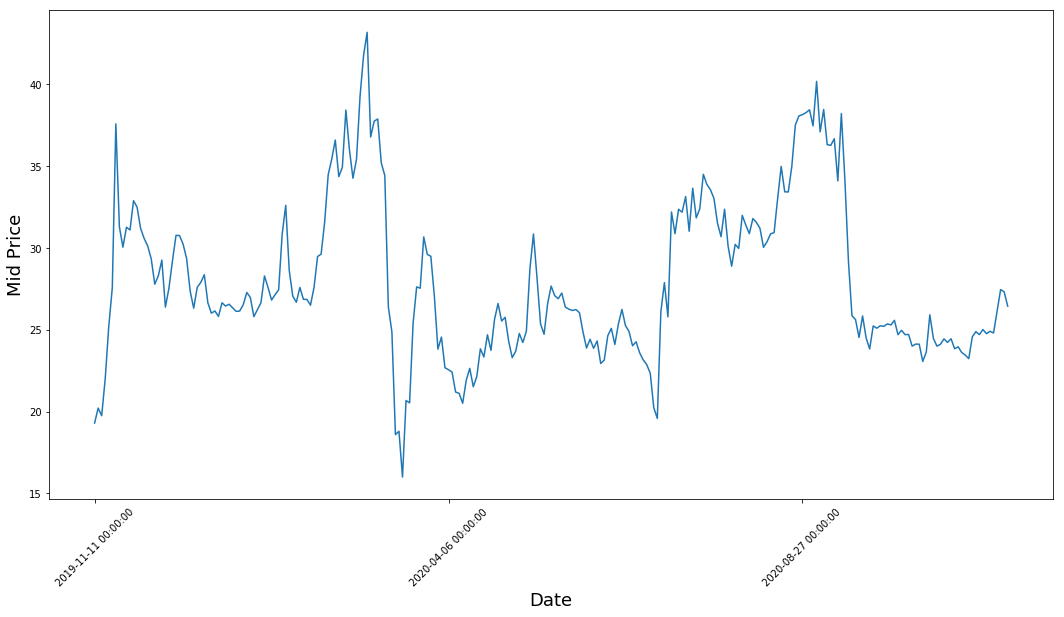

In [104]:
ETNB['date'] = pd.to_datetime(ETNB['date'], format='%Y-%m-%d')
ETNB.sort_values(by="date", ascending=True, inplace=True)
ETNB['high'] = ETNB['high'].astype(float)
ETNB['low'] = ETNB['low'].astype(float)
plt.figure(figsize = (18,9))
plt.plot(range(ETNB.shape[0]),(ETNB['low']+ETNB['high'])/2.0)
plt.xticks(range(0,ETNB.shape[0],100),ETNB['date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [106]:
df_new[df_new['Ticker'] == 'ETNB']

,Exchange,Ticker,Country,Name,Market Cap ($M),Trial_count
0,NASDAQ,ETNB,US,"89bio, Inc.",520,1
